input dimensions:  8 number of actions:  4
input dimensions:  8 number of actions:  4
Episode:  0 	Score:  -311.46068387185153 	Average Score: -311.461 Epsilon 0.984
Episode:  1 	Score:  -317.8146913657247 	Average Score: -314.638 Epsilon 0.939
Episode:  2 	Score:  -268.7126554569255 	Average Score: -299.329 Epsilon 0.898
Episode:  3 	Score:  -81.82991749263017 	Average Score: -244.954 Epsilon 0.835
Episode:  4 	Score:  -90.62818256102538 	Average Score: -214.089 Epsilon 0.798
Episode:  5 	Score:  -375.5154459468621 	Average Score: -240.994 Epsilon 0.746
Episode:  6 	Score:  -117.35220393100788 	Average Score: -223.331 Epsilon 0.717
Episode:  7 	Score:  -341.50194085556905 	Average Score: -238.102 Epsilon 0.673
Episode:  8 	Score:  -184.8356554410197 	Average Score: -232.183 Epsilon 0.640
Episode:  9 	Score:  -219.94465075495413 	Average Score: -230.960 Epsilon 0.597
Episode:  10 	Score:  -109.91238723853496 	Average Score: -219.955 Epsilon 0.567
Episode:  11 	Score:  -333.106238264455

Episode:  102 	Score:  259.59861673621936 	Average Score: 19.903 Epsilon 0.050
Episode:  103 	Score:  -65.16399645430849 	Average Score: 18.967 Epsilon 0.050
Episode:  104 	Score:  320.2310334662579 	Average Score: 22.959 Epsilon 0.050
Episode:  105 	Score:  69.85417601500554 	Average Score: 24.672 Epsilon 0.050
Episode:  106 	Score:  -66.80108108694623 	Average Score: 23.021 Epsilon 0.050
Episode:  107 	Score:  208.1346380194614 	Average Score: 27.519 Epsilon 0.050
Episode:  108 	Score:  248.05266475163174 	Average Score: 32.635 Epsilon 0.050
Episode:  109 	Score:  39.198331268490136 	Average Score: 34.634 Epsilon 0.050
Episode:  110 	Score:  8.19583350596173 	Average Score: 35.988 Epsilon 0.050
Episode:  111 	Score:  -16.121957192584958 	Average Score: 36.590 Epsilon 0.050
Episode:  112 	Score:  254.0238695036078 	Average Score: 42.059 Epsilon 0.050
Episode:  113 	Score:  -25.64082198012298 	Average Score: 40.858 Epsilon 0.050
Episode:  114 	Score:  235.97075844187384 	Average Score:

Episode:  206 	Score:  232.32779710804832 	Average Score: 161.440 Epsilon 0.050
Episode:  207 	Score:  120.83046822139569 	Average Score: 163.268 Epsilon 0.050
Episode:  208 	Score:  295.77296367465067 	Average Score: 168.810 Epsilon 0.050
Episode:  209 	Score:  272.0214581654265 	Average Score: 168.738 Epsilon 0.050
Episode:  210 	Score:  234.55754429935305 	Average Score: 172.388 Epsilon 0.050
Episode:  211 	Score:  267.13125644013655 	Average Score: 173.983 Epsilon 0.050
Episode:  212 	Score:  289.7454254054172 	Average Score: 175.127 Epsilon 0.050
Episode:  213 	Score:  288.59950292124574 	Average Score: 175.729 Epsilon 0.050
Episode:  214 	Score:  283.0021510129776 	Average Score: 180.556 Epsilon 0.050
Episode:  215 	Score:  259.2557733618725 	Average Score: 182.410 Epsilon 0.050
Episode:  216 	Score:  260.57034560668353 	Average Score: 188.412 Epsilon 0.050
Episode:  217 	Score:  242.51228743840295 	Average Score: 188.195 Epsilon 0.050
Episode:  218 	Score:  246.72363956233676 	A

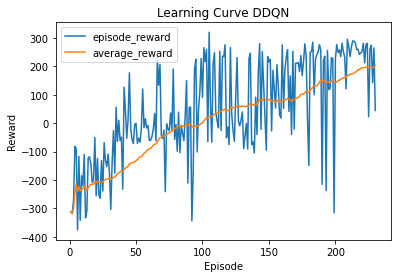

In [1]:
import gym
import os

import matplotlib.pyplot as plt
import numpy as np
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# Deep Q Network
class DQN(nn.Module):
    def __init__(self,learning_rate,input_dims,fc1_dims,fc2_dims,num_actions):
        super(DQN,self).__init__()
        
        print("input dimensions: ",input_dims[0],"number of actions: ",num_actions)
        
        # Three fully connected layers
        self.fc1 = nn.Linear(*input_dims,fc1_dims) # * unpacks the list of input_dims since it's 2-dimensional (same as input_dims[0])
        self.fc2 = nn.Linear(fc1_dims,fc2_dims)
        self.fc3 = nn.Linear(fc2_dims,num_actions)
        
        self.optimizer = optim.Adam(self.parameters(),lr=learning_rate)
        self.loss = nn.MSELoss()
        
        # Set device
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu:0')
        self.to(self.device)
        
    def forward(self,state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
# Agent 
class Agent:
    def __init__(self,discount,epsilon,learning_rate,input_dims,batch_size,num_actions,mem_size=500000,min_epsilon=0.05,epsilon_decay=0.0005):
        # Brain of the agent
        self.DQN = DQN(learning_rate,input_dims,256,256,num_actions)
        self.DQN_next = DQN(learning_rate,input_dims,256,256,num_actions)
        self.DQN_next.load_state_dict(self.DQN.state_dict()) # loads a model's parameter dictionary using a deserialized state_dict
        
        # Hyper-parameters
        self.discount = discount
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.action_space = [i for i in range(num_actions)]
        self.mem_size = mem_size
        self.batch_size = batch_size
        self.mem_counter = 0
        
        # Initialize memory 
        self.state_mem = np.zeros((mem_size,*input_dims),dtype=np.float32) # mem_size number of dim[0]*dim[1] matrices of zeros
        self.new_state_mem = np.zeros((mem_size,*input_dims),dtype=np.float32)
        self.action_mem = np.zeros(mem_size,dtype=np.int32)
        self.reward_mem = np.zeros(mem_size,dtype=np.float32)
        self.terminal_mem = np.zeros(mem_size,dtype=bool) # boolean value indicating whether it's the last memory
        
    # Store records inside the memory
    def storage(self,state,new_state,action,reward,terminal):
        index = self.mem_counter%self.mem_size # equal to mem_counter if mem_counter < mem_size
        self.state_mem[index] = state
        self.new_state_mem[index] = new_state
        self.reward_mem[index] = reward
        self.action_mem[index] = action
        self.terminal_mem[index] = terminal
        
        self.mem_counter += 1
        
    # Take actions
    def get_action(self,observation):
        if np.random.random() < self.epsilon:
            # Randomly choose one action from the action space
            action = np.random.choice(self.action_space)
        else:
            state = T.tensor([observation]).to(self.DQN.device)
            actions = self.DQN(state.float()) # same as self.to(torch.float32)
            action = T.argmax(actions).item() # the action corresponding to the index of the maximizing action in the actions tensor
        return action
    
    # Learning
    def learn(self):
        # Check memory counter against batch size since the latter comes from the former
        if self.mem_counter < self.batch_size:
            return
        
        # Initialize gradients
        self.DQN.optimizer.zero_grad()
        
        # Generate batch such that the batch size is smaller than the number of results in the memory
        max_batch = min(self.mem_counter,self.mem_size)
        batch = np.random.choice(max_batch,self.batch_size,replace=False)
        batch_index = np.arange(self.batch_size,dtype=np.int32)
        
        state_batch = T.tensor(self.state_mem[batch]).to(self.DQN.device)
        new_state_batch = T.tensor(self.new_state_mem[batch]).to(self.DQN.device)
        reward_batch = T.tensor(self.reward_mem[batch]).to(self.DQN.device)
        terminal_batch = T.tensor(self.terminal_mem[batch]).to(self.DQN.device)
        action_batch = self.action_mem[batch] # cannot follow the above format since used as index
        
        q_next = self.DQN_next(new_state_batch)
        q_eval = self.DQN(new_state_batch)
        best_action = T.argmax(q_eval,dim=1).int().cpu().numpy()
        
        q_target = reward_batch+self.discount*q_next[batch_index,best_action]
        q_pred = self.DQN(state_batch)[batch_index,action_batch]
        q_target[terminal_batch] = 0.0
        
        # Backprop 
        loss = self.DQN.loss(q_target,q_pred).to(self.DQN.device)
        loss.backward() # get the gradient of the current tensor
        self.DQN.optimizer.step()
        self.update_epsilon()
        
    # Epsilon decay
    def update_epsilon(self):
        if self.epsilon > self.min_epsilon:
            self.epsilon = self.epsilon-self.epsilon_decay
    
    def update_network(self):
        self.DQN_next.load_state_dict(self.DQN.state_dict())      

        
# Model training
if __name__=='__main__':
    env = gym.make("LunarLander-v2")
    input_dims = [env.observation_space.shape[0]]
    num_actions = env.action_space.n
    discount = 0.99
    epsilon = 1.0
    learning_rate = 0.001
    batch_size = 64
    
    agent = Agent(discount,epsilon,learning_rate,input_dims,batch_size,num_actions)
    
    scores = []
    avg_scores = []
    episodes = 500
    learn = True
    
    for i in range(episodes):
        score = 0
        state = env.reset()
        done = False
        
        while not done:
            action = agent.get_action(state)
            new_state,reward,done,info = env.step(action)
            
            if i%10 == 0:
                env.render()
            
            score += reward
            
            agent.storage(state,new_state,action,reward,done)
            if learn:
                agent.learn()
                # Update target every 5 episodes
                if i%5 == 0  and i != 0:
                    agent.update_network()
                    
            state = new_state
            
        scores.append(score)
        avg_score = np.mean(scores[-50:])
        avg_scores.append(avg_score)
        print("Episode: ",i,"\tScore: ",score,"\tAverage Score: %.3f"% avg_score,"Epsilon %.3f" % agent.epsilon)
        
        # Early stopping when average score of the last 10 episodes is above 200
        if np.mean(scores[-50:]) > 200:
            episodes = i+1
            break
    
    checkpoint = {"model":agent.DQN.state_dict(),"score":scores,"episodes":episodes} 
    #save_dir = "C:/Users/Yang Yue/OneDrive/Documents/GitHub/STAT_430/prep/"
    save_dir = "/Users/Yang/OneDrive/Documents/GitHub/STAT_430/prep/"
    T.save(checkpoint,save_dir+"lunarlander-DDQN.pt")
    
    x = [i+1 for i in range(episodes)]
    plt.plot(x,scores,label="episode_reward")
    plt.plot(x,avg_scores,label="average_reward")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Learning Curve DDQN")
    plt.legend()
    plt.show() 